In [1]:
import torch
import gc
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%autoreload 2

from EVO import LogisticRegression, DeepNeuralNetwork, EvolutionOptimizer, GradientDescentOptimizer

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps"  if torch.backends.mps.is_available()
    else "cpu"
)

In this notebook, I will investigate how different diversity metrics can be used to evaluate and guide the evolution of weight vectors in an evolutionary optimization algorithm. Maintaining diversity in a population is important to avoid early convergence and ensuring a wide search of the solution space.

I'll compare three key metrics:
- Euclidean Distance: Average pairwise L2 distance between weight vectors.
- Cosine Dissimilarity: Measures angular difference between vectors, emphasizing directional diversity.
- Standard Deviation: Measures per-dimension spread across the population.

Using a trained EvolutionOptimizer, I will:

- Quantify diversity using these metrics at a given generation.
- Visualize how these metrics compare.
- Track how diversity evolves across multiple generations.

This exploration will help us better understand which diversity metrics align with better performance and how they might influence future adaptations to the algorithm.

## Step 1: Load and Preprocess MNIST Data

In [2]:
from torch.utils.data import Subset

# Define a transform that converts images to a tensor and flattens them.
transform = transforms.Compose([
    transforms.ToTensor(),                    # MNIST images are [1, 28, 28]
    transforms.Lambda(lambda x: x.view(-1))    # Flatten to [784]
])

# Load the MNIST training and test sets.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Build training tensors
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
y_train = torch.tensor([float(train_dataset[i][1]) for i in range(len(train_dataset))], dtype=torch.long)
X_train = X_train[:20000]
y_train = y_train[:20000]

# Build test tensors
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
y_test = torch.tensor([float(test_dataset[i][1]) for i in range(len(test_dataset))], dtype=torch.long)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

### From Binary to Multiclass Classification

In prior versions of our source code, our DeepNeuralNetwork model used binary cross entropy loss because it was solving a binary classification - i.e. whether an MNIST image had a digit <= 4 or >4.

Binary cross entropy works when there are two target values (like 0 and 1) and a classification model outputs a single score per input to aid in a classification, which we have usually normalized to a value between 0 and 1 using the sigmoid function.

However, moving forward into this project, we are trying to solve multiclass classification problems. In other words, there are more than two possible target values.

In the MNIST dataset, each handwritten image could be a digit from 0 to 9. As such, we need 10 possible classes - 0, 1, 2, 3... 9 - instead of just 2.

For a multiclass problem, we can use Cross Entropy Loss. This is different from BCE as it accepts multiple output scores from the model (these are called logits).

The Cross Entropy function automatically applies what is called a SoftMax function to the logits which it receives, which turns those logits into probabilities. It then can be used to compute the loss based on how much probability the model assigned to the correct class.

In our DeepNeuralNetwork class, we currently used PyTorch's implementation of CrossEntropy - torch.nn.CrossEntropyLoss - to handle this.

Below is an example of how to use CrossEntropyLoss for a multiclass problem:

In [3]:
import torch.nn as nn

"""
Imagine we have three images in our dataset,
and had our model produce 10 logits for each image.
"""

logits_right = torch.tensor([
    [2.0, 1.0, 0.1, -1.0, 3.0, 0.5, -0.5, 1.2, 2.2, 0.0],
    [0.5, 2.2, 1.5, -0.5, 0.1, 3.0, 1.0, -1.0, 0.7, 2.5],
    [1.0, 0.8, 2.0, 1.5, 0.2, 0.5, -0.2, 1.0, 2.5, 0.1]
])

"""
From these logits, we can see that our model predicted image 1
to be a 4, image 2 to be a 5, and image 3 to be an 8. This is
because the highest logit value can be found at their corresponding
indices in the logit lists.

However, it did not do so with total confidence. In other words,
the model predicted that there was a smaller but existing probability
that each image could contain another image.

So, let's see how that affects the Cross Entropy Loss
"""
labels = torch.tensor([4, 5, 8])

# Create loss function obj for Cross Entropy
CE = nn.CrossEntropyLoss()

# Compute the loss
loss_right = CE(logits_right, labels)

print(f"Cross Entropy Loss (Correct Classification): {loss_right.item():.4f}")

"""
But what if it made an incorrect prediction?
"""

logits_wrong = torch.tensor([
    [2.0, 1.0, 0.1, -1.0, 1.5, 0.5, -0.5, 1.2, 2.2, 0.0],  # Image 1
    [0.5, 2.2, 1.5, -0.5, 0.1, 2.5, 1.0, -1.0, 0.7, 3.0],  # Image 2
    [1.0, 0.8, 2.0, 2.5, 0.2, 0.5, -0.2, 1.0, 2.0, 0.1]   # Image 3
])

loss_wrong = CE(logits_wrong, labels)

print(f"Cross Entropy Loss (Wrong Classification): {loss_wrong.item():.4f}")

"""
And now, what if the model's predictions were perfect?
(i.e. the correct class logit is very positive, and very
negative for all other classes)
"""
logits_perfect = torch.tensor([
    [-10.0, -10.0, -10.0, -10.0, 1000.0, -10.0, -10.0, -10.0, -10.0, -10.0],  # Image 1
    [-10.0, -10.0, -10.0, -10.0, -10.0, 1000.0, -10.0, -10.0, -10.0, -10.0],  # Image 2
    [-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, 1000.0, -10.0]   # Image 3
])

loss_perfect = CE(logits_perfect, labels)

print(f"Cross Entropy Loss (Wrong Classification): {loss_perfect.item():.4f}")

Cross Entropy Loss (Correct Classification): 0.9822
Cross Entropy Loss (Wrong Classification): 1.7076
Cross Entropy Loss (Wrong Classification): 0.0000


EXPLAIN ABOVE EXPERIMENT

## Exploring Diversity Metrics: The Diversity Metrics We Chose in this Experiment

### *In this section of our project, we implemented four different diversity metrics to help guide the evolutionary optimization process for our Deep Neural Network (DNN). We used diversity as a penalty/bonus in our loss function to encourage the weight vector population to stay varied, preventing premature convergance on a non-optimal weight vector solution, and promoting wide exploration of possible solutions. Below is an explanation of each metric and how it is implemented:*

1. Euclidean Distance: Euclidean distance tells use the average "straight-line" distance between pairs of individuals in the population. In our case, this is done by computing the total distance - the square root of the sum of constituent pairwise distances - between each pair of vectors in the population. In our code, we do this by normalizing the difference between pairs of weight vectors in our population (`python torch.norm(weight_vector_i - weight_vector_j)) and then averaging that value for all weight vectors in the population. Higher output values for this metric represent that individuals are spread out in space - that they have diverse weights between them - and thus that they have a higher diversity.

2. Cosine Dissimilarity: Cosine Dissimilarity tells us about the difference between weight vectors based on the angles of those vectors in space (not including magnitude). I implemented this by normalizing our vectors, to eliminate the effect of their magnitudes, and creating a matrix with all of our weight vectors. I then perform matrix multiplication between this matrix and its transpose, resulting in a matrix where each entry is the cosine similarity between two vectors (as the dot product of two normalized vectors is their cosine similarity). Then, we subtract this value from 1 for every entry in the matrix, and return the mean of this to get the average cosine dissimilarity for all vectors in our population. A high value here means that individual weight vectors point in different directions/have different angles in feature space.

3. Standard Deviation: Standard deviation measures how spread out our weights are in each dimension, and then averaging this value out across all dimensions. In other words, it tells us how much variation there is across the population for each individual weight. If all weight vectors vary significantly in the same weight component, then the standard deviation will be large. It is a simple and computationally cheap approximation of diversity, and is implemented with the torch.std() function that calculates standard deviation across a tensor. A high standard deviation means we have more dispersed weights.

4. Variance: Variance is similar to standard deviation in that is measures the spread of weights in our feature dimensions, but keeps the square value of the spread to emphasize larger differences. To clarify, variance is the square of standard deviation. Thus, while it similarly measures variation across each weight, it puts more emphasis on outliers. As such, variance can be more helpful in penalizing tight clustering than standard deviation. This is implemented by using torch.var() across a weight vector population, and then averaging this across all dimensions to calculate average variance. Again, high variance means high diversity.

In our EvolutionOptimizer class, the diversity metric can dynamically be set using the set_diversity_metric() function. When we then compute diversity, the model automatically adjusts the loss function by abstractly calculating the diversity term (diversity_term = self.optimizer.compute_diversity()). In our model's loss function, we include this diversity term to introduce a diversity penalty - i.e. a less diverse population will result in higher loss - alongside traditional classification loss. Here is the key line of code which can be found in the source code:

`return loss - (self.diversity_coeff * diversity_term)`

In this code, `loss` is the actual loss which is calculated using the traditional Cross Entropy loss function from torch.nn. The `self.diversity_coeff` is a scalar indicates how strongly we reward high diversity - or really how much we punish low diversity. The `diversity_term` measures how spread our population is. This, when diversity is low, the diversity term is small and loss will be higher. If diversity is high, then more will be subtracted from loss, rewarding us with lower total loss. These will both be amplified by a higher diversity_coeff value. All of this encourages the optimizer to keep the populating diverse, promoting deeper exploration. Ultimately, this can be understood as a form of regularization which penalizes a lack of diversity rather than large weights.

## Comparative Training Loops: How Diversity Metrix Impacts Model Performance/Training

This section compares how different diversity metrics affect model performance during evolution-optimized DNN training. We will hold all parameters other than diversity metric constant, and track accuracy, cross-entropy loss (adjusted for diversity), and diversity values over time.

In [4]:
# Define Training Function
def run_diversity_experiment(diversity_metric, generations=100):
    # Set up model and optimizer
    layer_dimensions = [784, 64, 10]
    DNN = DeepNeuralNetwork(layer_dimensions)
    EVO_OPT = EvolutionOptimizer(DNN)
    DNN.set_optimizer(EVO_OPT)
    EVO_OPT.population = []

    # Set Diversity Settings
    EVO_OPT.set_population_size(50)
    EVO_OPT.set_mutation_rate(0.4)
    EVO_OPT.set_mutation_intensity(0.5)
    EVO_OPT.set_diversity_coeff(0.1)
    EVO_OPT.set_diversity_metric(diversity_metric)

    # Set up performance/value tracking arrays
    accuracies = []
    losses = []
    diversities = []

    # Training Loop
    for gen in range(generations + 1):

        # Perform one step on population
        EVO_OPT.step(X_train, y_train)

        # Evaluate current DNN state on Test Set
        with torch.no_grad():
            logits = DNN.forward(X_test[:300])
            preds = torch.argmax(logits, dim=1)
            acc = (preds == y_test[:300].to(DNN.device)).float().mean().item()

        # Log every 10 generations
        if gen % 10 == 0:
            with torch.no_grad():
                accuracies.append(acc * 100)
                losses.append(DNN.curr_loss)
                diversities.append(DNN.curr_diversity)
        
        if gen % 5 == 0:
            gc.collect()
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

    del DNN, EVO_OPT, logits, preds
    gc.collect()
    torch.cuda.empty_cache()

    return (accuracies, losses, diversities)

# Because not all diversity metrics produce values in same range, normalize them for comparison
def normalize_diversities(diversities):
    diversities_min = min(diversities)
    diversities_max = max(diversities)
    return [(x - diversities_min) / (diversities_max - diversities_min + 1e-8) for x in diversities]

In [5]:
# Test for All Metrics

all_results = {}
diversity_metrics = ["euclidean", "cosine", "std", "variance"]

for metric in diversity_metrics:
    print(f"Running Baseline for {metric}")
    accuracies, losses, diversities = run_diversity_experiment(metric)
    all_results[metric] = {
        "accuracies": accuracies,
        "losses": losses,
        "raw_diversities": diversities,
        "normalized_diversities": normalize_diversities(diversities)
    }

Running Baseline for euclidean
Running Baseline for cosine
Running Baseline for std
Running Baseline for variance


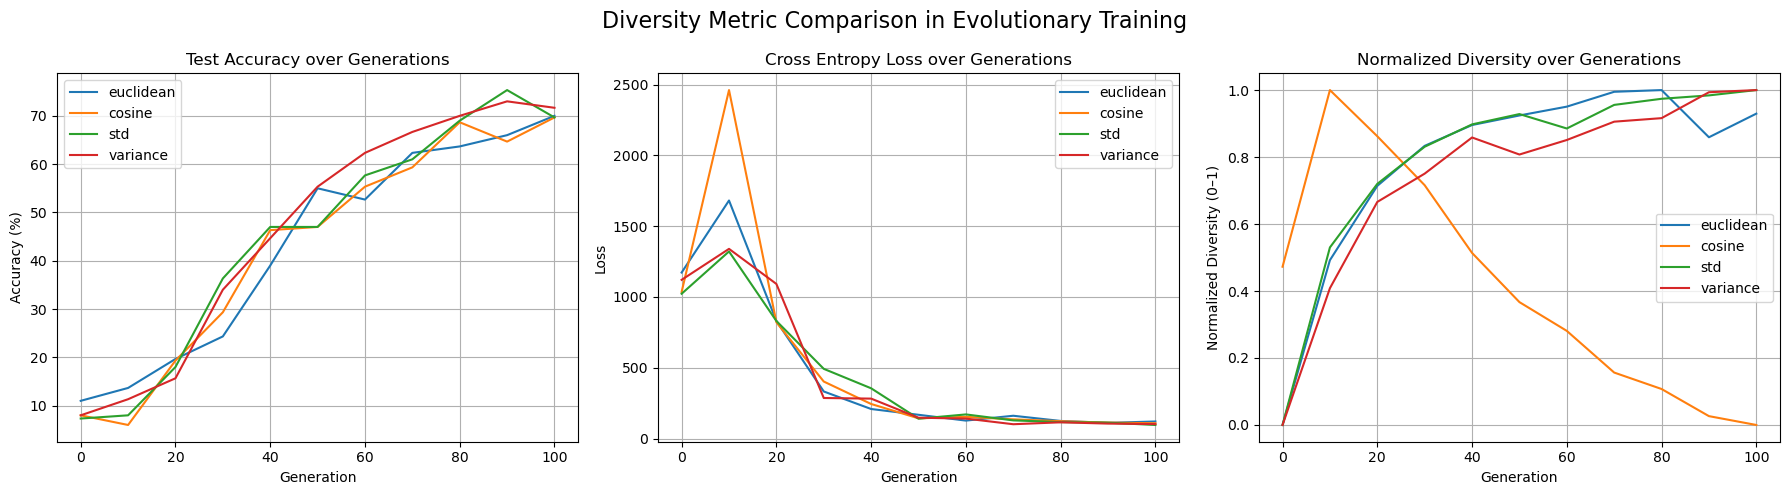

In [6]:
import matplotlib.pyplot as plt

# Set x-axis (generations every 10 steps)
generations = [i * 10 for i in range(len(all_results[metric]['accuracies']))]
metrics = list(all_results.keys())

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Accuracy
for metric in metrics:
    axs[0].plot(generations, all_results[metric]['accuracies'], label=metric)
axs[0].set_title("Test Accuracy over Generations")
axs[0].set_xlabel("Generation")
axs[0].set_ylabel("Accuracy (%)")
axs[0].legend()
axs[0].grid(True)

# Plot Cross-Entropy Loss
for metric in metrics:
    axs[1].plot(generations, all_results[metric]['losses'], label=metric)
axs[1].set_title("Cross Entropy Loss over Generations")
axs[1].set_xlabel("Generation")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# Plot Normalized Diversity
for metric in metrics:
    axs[2].plot(generations, all_results[metric]['normalized_diversities'], label=metric)
axs[2].set_title("Normalized Diversity over Generations")
axs[2].set_xlabel("Generation")
axs[2].set_ylabel("Normalized Diversity (0–1)")
axs[2].legend()
axs[2].grid(True)

plt.suptitle("Diversity Metric Comparison in Evolutionary Training", fontsize=16)
plt.tight_layout()
plt.show()


## Finding the Optimal Setup (For Euclidean Distance)

In [7]:

def test_diversity_parameters(
        metric,
        coeff,
        mutation_rate,
        mutation_intensity,
        population_size,
        generations
    ):
    # Set up model and optimizer
    layer_dimensions = [784, 64, 10]
    DNN = DeepNeuralNetwork(layer_dimensions)
    EVO_OPT = EvolutionOptimizer(DNN)
    DNN.set_optimizer(EVO_OPT)
    EVO_OPT.population = []

    # Set Diversity Settings
    EVO_OPT.set_population_size(population_size)
    EVO_OPT.set_mutation_rate(mutation_rate)
    EVO_OPT.set_mutation_intensity(mutation_intensity)
    EVO_OPT.set_diversity_coeff(coeff)
    EVO_OPT.set_diversity_metric(metric)

    # Set up performance/value tracking arrays
    accuracies = []
    losses = []
    diversities = []

    # Training Loop
    for gen in range(generations + 1):
        # Perform one step on population
        EVO_OPT.step(X_train, y_train)

        # Evaluate current DNN state on Test Set
        with torch.no_grad():
            logits = DNN.forward(X_test[:300])
            preds = torch.argmax(logits, dim=1)
            acc = (preds == y_test[:300].to(DNN.device)).float().mean().item()

        # Log every 10 generations
        if gen % 10 == 0:
            with torch.no_grad():
                accuracies.append(acc * 100)
                losses.append(DNN.curr_loss)
                diversities.append(DNN.curr_diversity)
        
        if gen % 5 == 0:
            gc.collect()
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

    del DNN, EVO_OPT, logits, preds
    gc.collect()
    torch.cuda.empty_cache()

    return (accuracies, losses, diversities)


In [8]:
def display_parameter_results(metric, 
                              accuracies, 
                              losses, 
                              diversities,
                              diversity_coeff, 
                              mutation_rate, 
                              mutation_intensity, 
                              population_size,  
                              generations_logged=None
                              ):
    
    if generations_logged is None:
        generations_logged = list(range(0, len(accuracies) * 10, 10))
    
    print(f"FINAL RESULTS")
    print(f"  Final Accuracy:  {accuracies[-1]:.2f}%")
    print(f"  Final Loss:      {losses[-1]:.4f}")
    print(f"  Final Diversity: {diversities[-1]:.4f}")

    
    fig, axs = plt.subplots(1, 3, figsize=(18,5))

    # Accuracy Plot
    axs[0].plot(generations_logged, accuracies, marker='o')
    axs[0].set_title(f"Accuracy over Generations ({metric})")
    axs[0].set_xlabel("Generation")
    axs[0].set_ylabel("Accuracy (%)")
    axs[0].grid(True)

    # Losses Plot
    axs[1].plot(generations_logged, losses, marker='x', color="red")
    axs[1].set_title(f"Cross Entropy Loss ({metric})")
    axs[1].set_xlabel("Generation")
    axs[1].set_ylabel("Loss")
    axs[1].grid(True)

    # Diversities Plot
    axs[2].plot(generations_logged, diversities, marker='s', color="green")
    axs[2].set_title(f"Diversity ({metric})")
    axs[2].set_xlabel("Generation")
    axs[2].set_ylabel("Diversity Value")
    axs[2].grid(True)

    plt.suptitle(f"Results for Hyperparameter Experiment "
                 f"Metric: {metric} | Diversity Coefficient: {diversity_coeff} | Mutation Rate: {mutation_rate} |"
                 f"Mutation Intensity: {mutation_intensity} | Population Size: {population_size}",
                 fontsize=14)
    plt.tight_layout()
    plt.show()


In [9]:
# Cosine 1: Baseline
accuracies_c1, losses_c1, diversities_c1 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  85.67%
  Final Loss:      14.9688
  Final Diversity: 0.0056


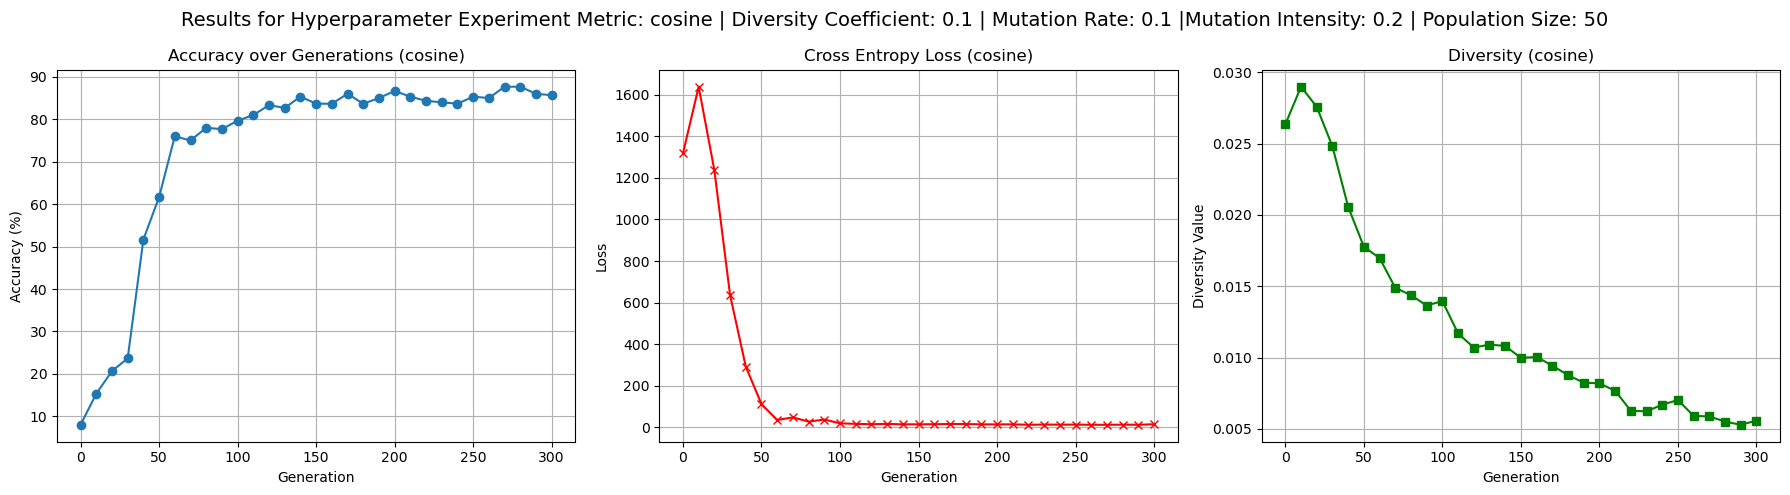

In [10]:
display_parameter_results("cosine", accuracies_c1, losses_c1, diversities_c1, 0.1, 0.1, 0.2, 50)

In [11]:
# Cosine 2: Lower Diversity Pressure
accuracies_c2, losses_c2, diversities_c2 = test_diversity_parameters(
    metric="cosine",
    coeff=0.01,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  85.67%
  Final Loss:      12.1673
  Final Diversity: 0.0005


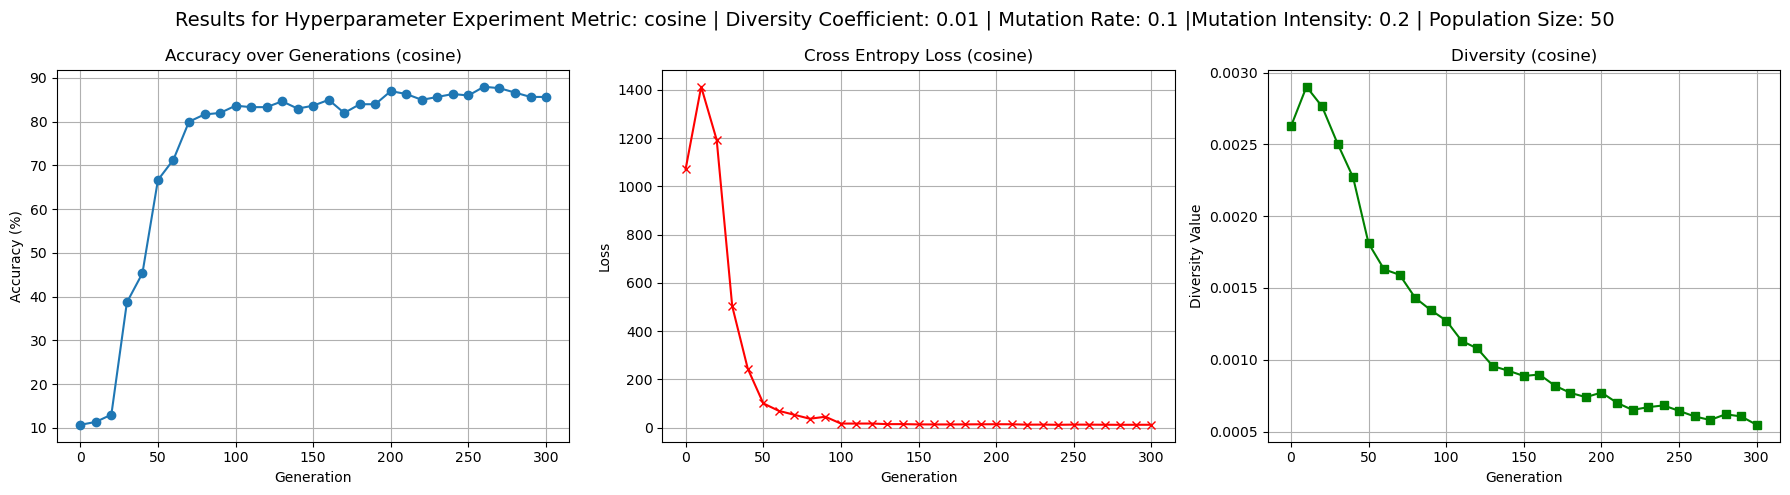

In [12]:
display_parameter_results("cosine", accuracies_c2, losses_c2, diversities_c2, 0.01, 0.1, 0.2, 50)

In [13]:
# Cosine 3: Higher Diversity Pressure
accuracies_c3, losses_c3, diversities_c3 = test_diversity_parameters(
    metric="cosine",
    coeff=0.5,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  88.67%
  Final Loss:      10.6429
  Final Diversity: 0.0271


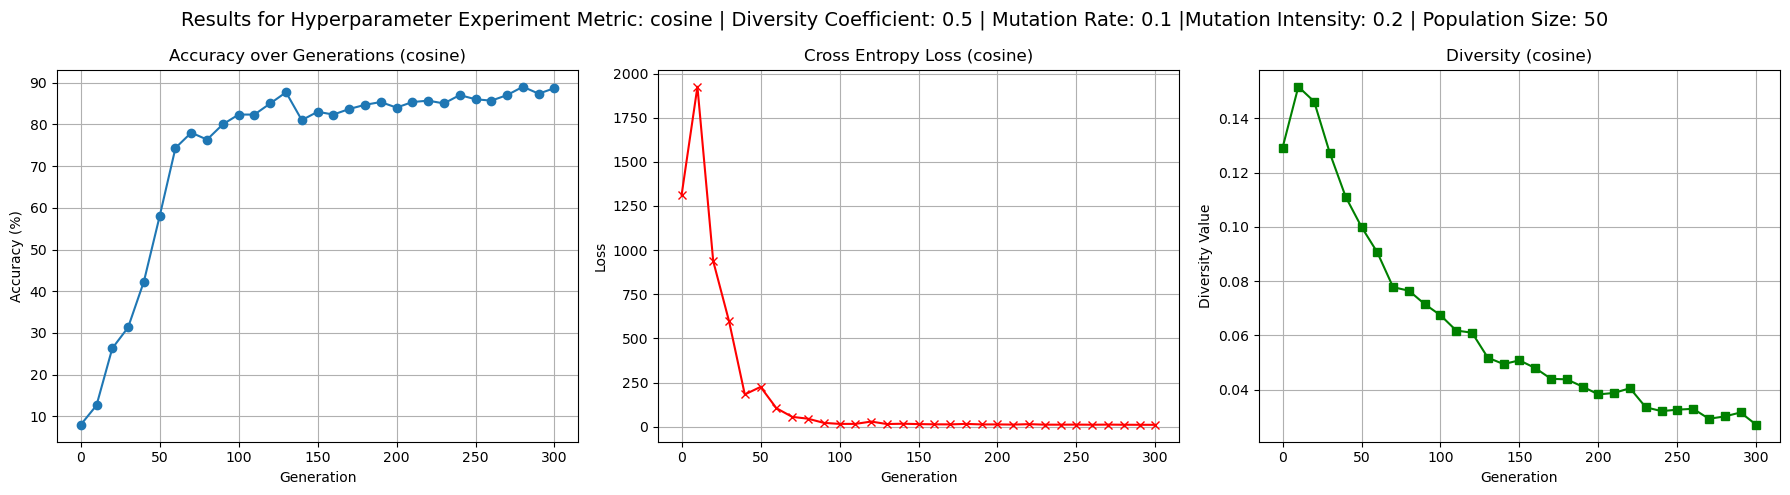

In [14]:
display_parameter_results("cosine", accuracies_c3, losses_c3, diversities_c3, 0.5, 0.1, 0.2, 50)

In [15]:
# Cosine 4: Lower Mutation Rate
accuracies_c4, losses_c4, diversities_c4 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.01,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  87.67%
  Final Loss:      5.5882
  Final Diversity: 0.0021


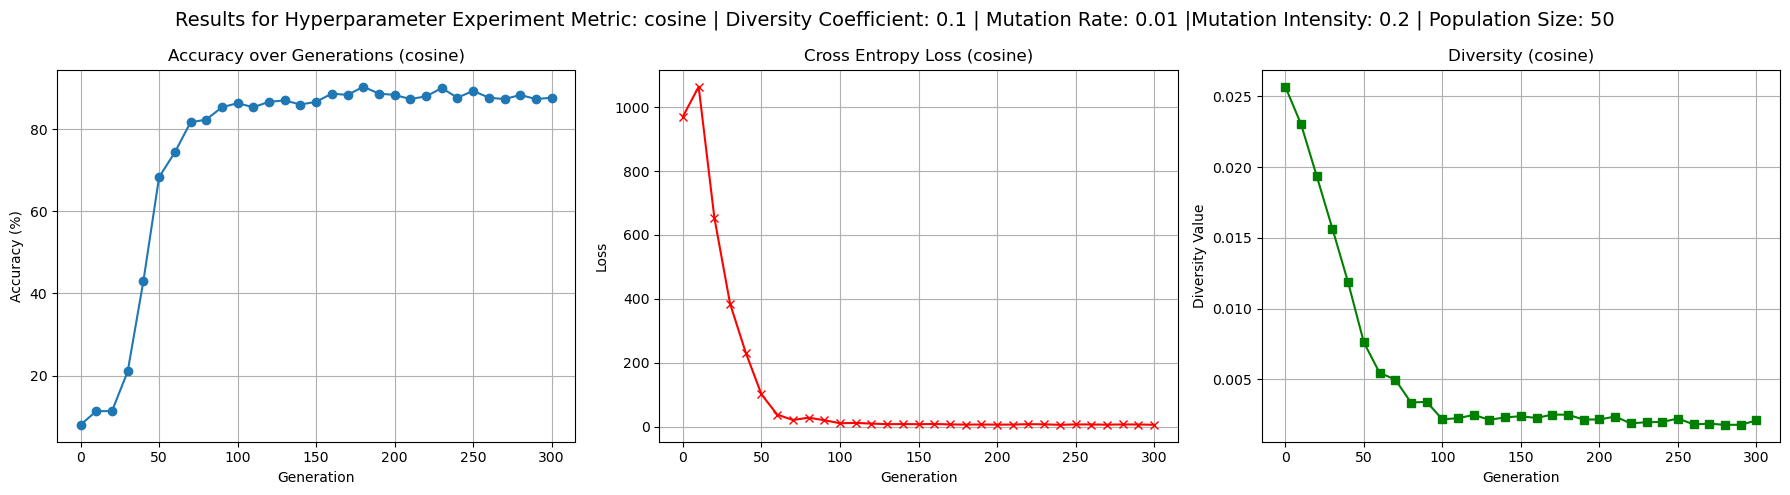

In [16]:
display_parameter_results("cosine", accuracies_c4, losses_c4, diversities_c4, 0.1, 0.01, 0.2, 50)

In [17]:
# Cosine 5: Higher Mutation Intensity
accuracies_c5, losses_c5, diversities_c5 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.5,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  83.67%
  Final Loss:      35.0913
  Final Diversity: 0.0070


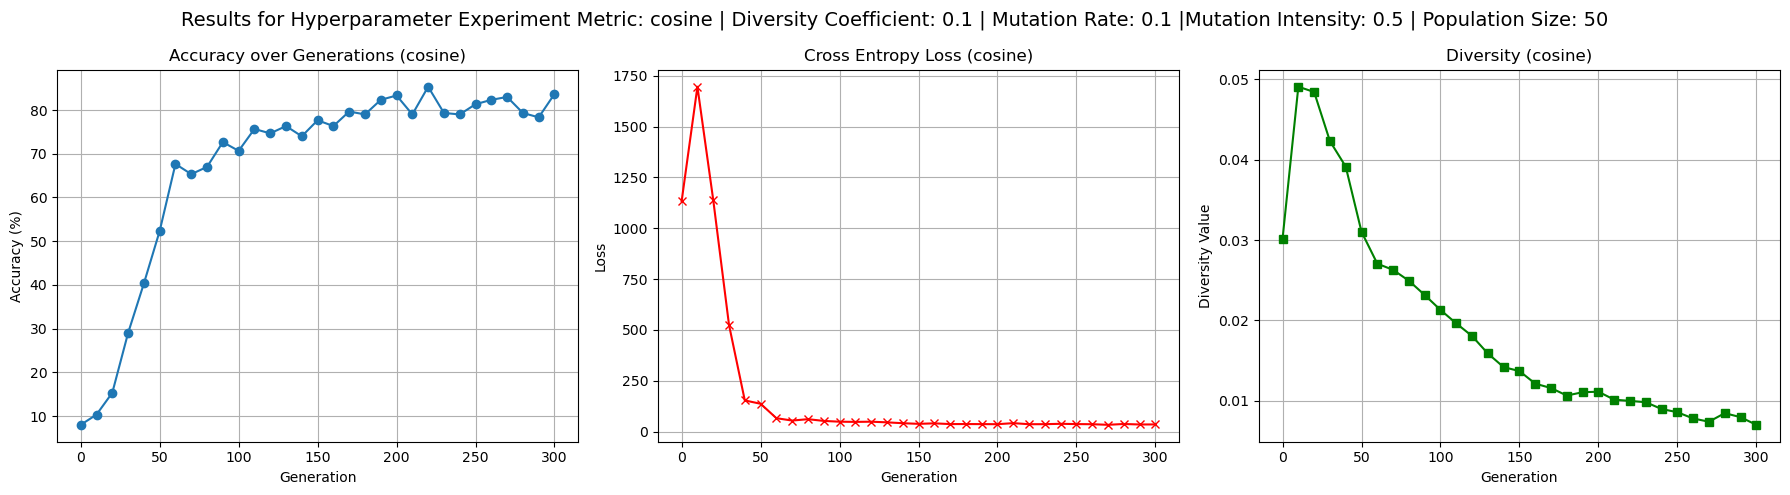

In [18]:
display_parameter_results("cosine", accuracies_c5, losses_c5, diversities_c5, 0.1, 0.1, 0.5, 50)

## Euclidean Distance Experiments

In [19]:
# Euclidean 1 (E1): Baseline
accuracies_e1, losses_e1, diversities_e1 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  88.00%
  Final Loss:      11.6712
  Final Diversity: 9.0324


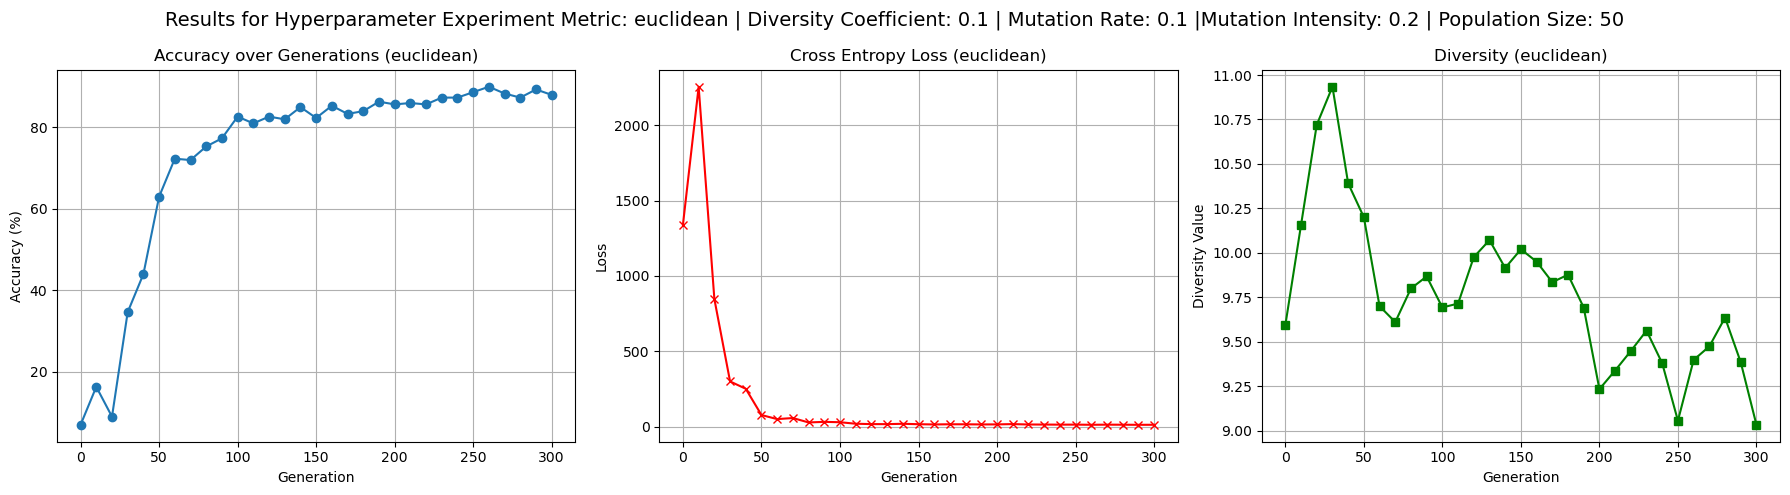

In [20]:
display_parameter_results("euclidean", accuracies_e1, losses_e1, diversities_e1, 0.1, 0.1, 0.2, 50)

In [21]:
# E2: Lower Diversity Pressure
accuracies_e2, losses_e2, diversities_e2 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.01,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  85.33%
  Final Loss:      13.4817
  Final Diversity: 0.9508


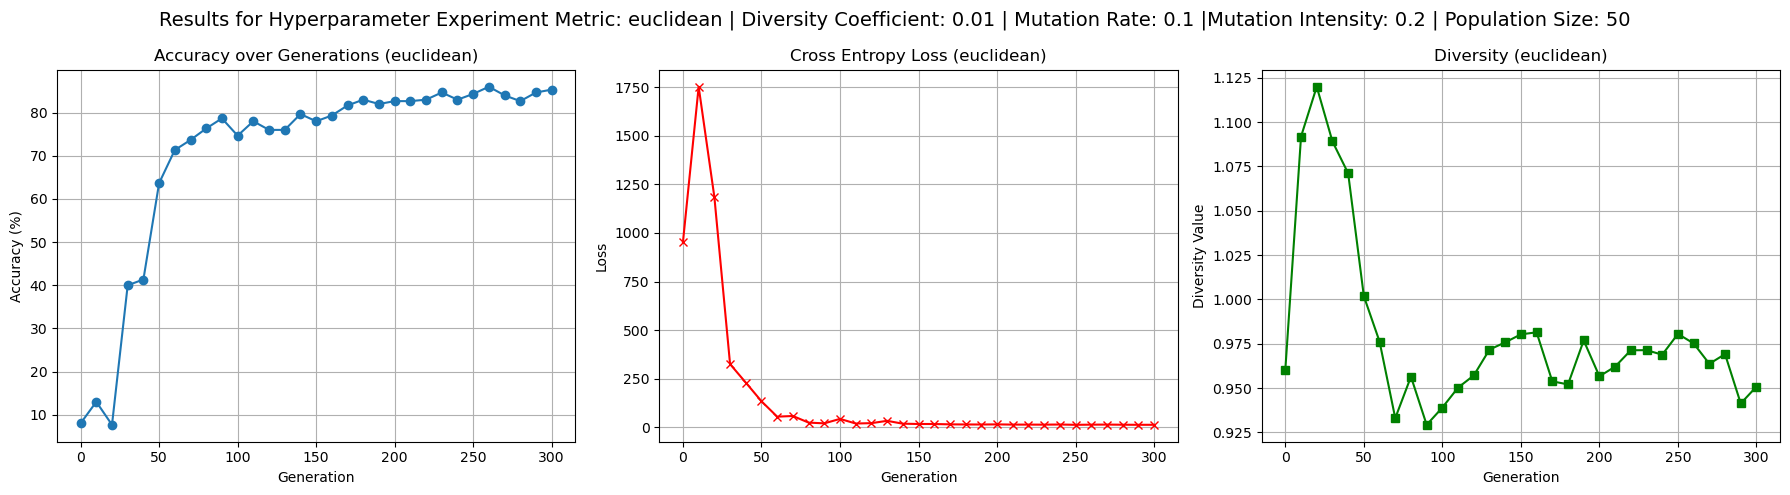

In [22]:
display_parameter_results("euclidean", accuracies_e2, losses_e2, diversities_e2, 0.01, 0.1, 0.2, 50)

In [23]:
# E3: Higher Diversity Pressure
accuracies_e3, losses_e3, diversities_e3 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.5,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  86.67%
  Final Loss:      10.1585
  Final Diversity: 46.7761


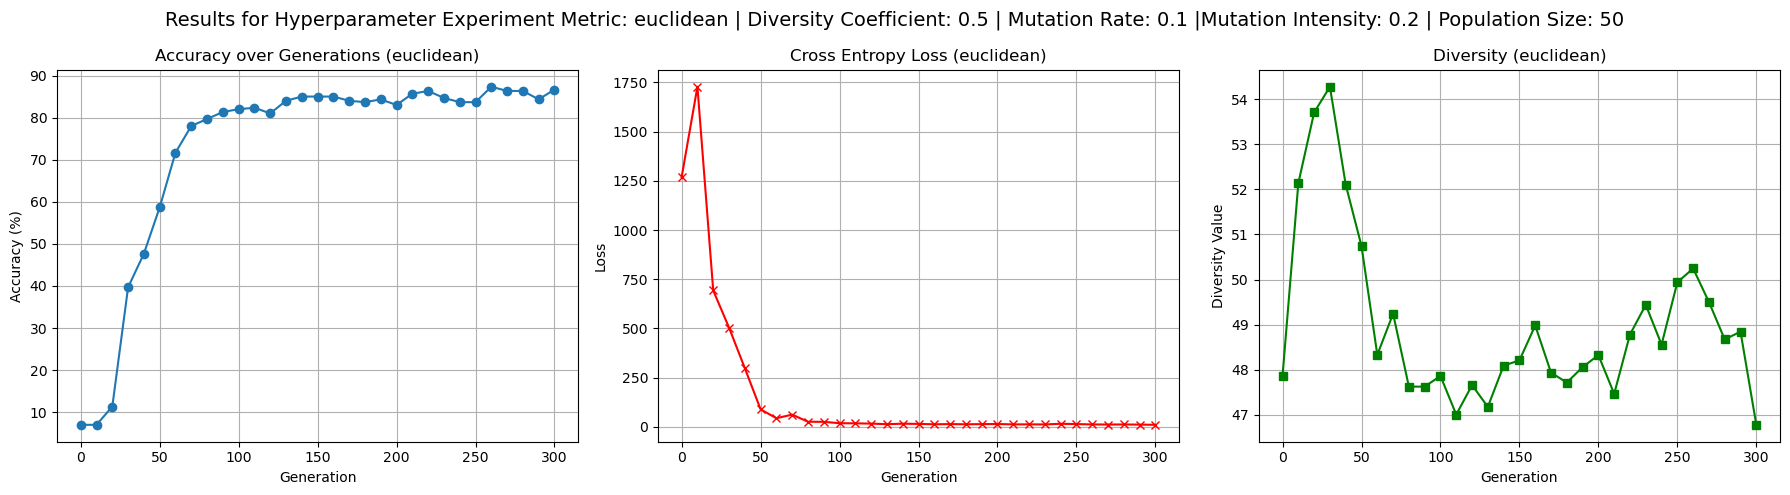

In [24]:
display_parameter_results("euclidean", accuracies_e3, losses_e3, diversities_e3, 0.5, 0.1, 0.2, 50)

In [25]:
# E4: Higher Mutation Rate
accuracies_e4, losses_e4, diversities_e4 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.5,
    mutation_intensity=0.2,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  81.33%
  Final Loss:      27.9161
  Final Diversity: 19.9499


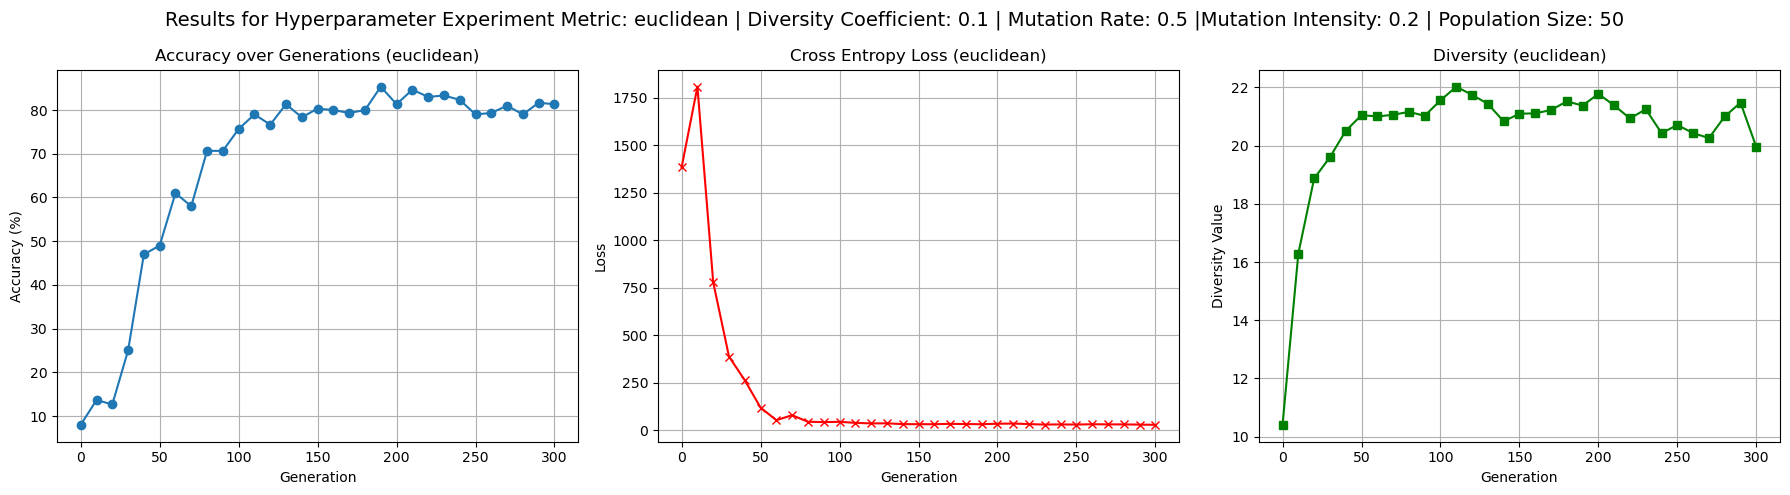

In [26]:
display_parameter_results("euclidean", accuracies_e4, losses_e4, diversities_e4, 0.1, 0.5, 0.2, 50)

In [27]:
# E5: Lower Mutation Intensity
accuracies_e5, losses_e5, diversities_e5 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.01,
    population_size=50,
    generations=300
)

FINAL RESULTS
  Final Accuracy:  91.67%
  Final Loss:      3.8855
  Final Diversity: 0.0197


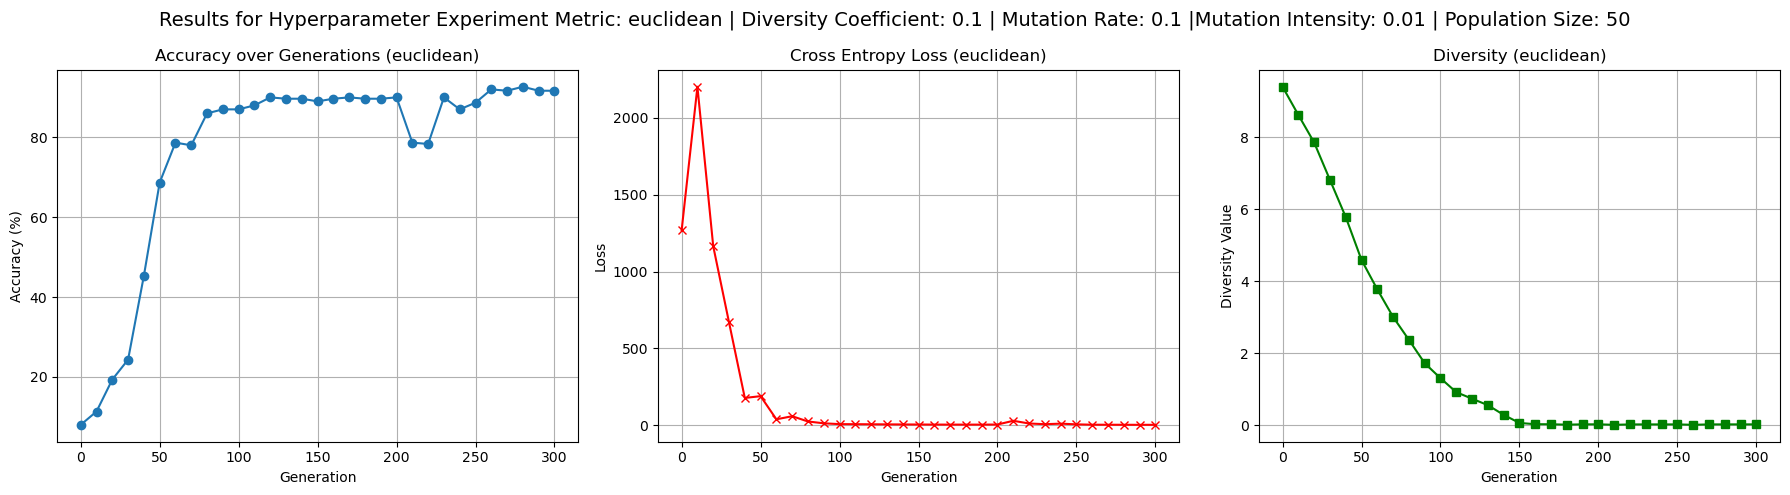

In [28]:
display_parameter_results("euclidean", accuracies_e5, losses_e5, diversities_e5, 0.1, 0.1, 0.01, 50)

## Population Size Experiments

In [29]:
def plot_population_comparison(results_dict, metric="cosine"):
    """
    Plot accuracy, loss, and diversity over generations for different population sizes.
    """
    # Assume all series have the same number of generations
    num_generations = len(list(results_dict.values())[0][0])
    generations = [i * 10 for i in range(num_generations)]


    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for pop_size, (accs, losses, divs) in results_dict.items():
        label = f"Population: {pop_size}"
        axs[0].plot(generations, accs, label=label)
        axs[1].plot(generations, losses, label=label)
        axs[2].plot(generations, divs, label=label)

    # Accuracy subplot
    axs[0].set_title("Accuracy over Generations")
    axs[0].set_xlabel("Generation")
    axs[0].set_ylabel("Accuracy (%)")
    axs[0].legend()
    axs[0].grid(True)

    # Loss subplot
    axs[1].set_title("Cross Entropy Loss over Generations")
    axs[1].set_xlabel("Generation")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True)

    # Diversity subplot
    axs[2].set_title(f"Diversity over Generations ({metric})")
    axs[2].set_xlabel("Generation")
    axs[2].set_ylabel("Diversity Value")
    axs[2].legend()
    axs[2].grid(True)

    plt.suptitle(f"Population Size Comparison using {metric} Diversity", fontsize=16)
    plt.tight_layout()
    plt.show()


In [30]:
# Population Size Experiments
accuracies_p1, losses_p1, diversities_p1 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=10,
    generations=300
)

accuracies_p2, losses_p2, diversities_p2 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=25,
    generations=300
)
 
accuracies_p3, losses_p3, diversities_p3 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=75,
    generations=300
)

accuracies_p4, losses_p4, diversities_p4 = test_diversity_parameters(
    metric="cosine",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=100,
    generations=300
)

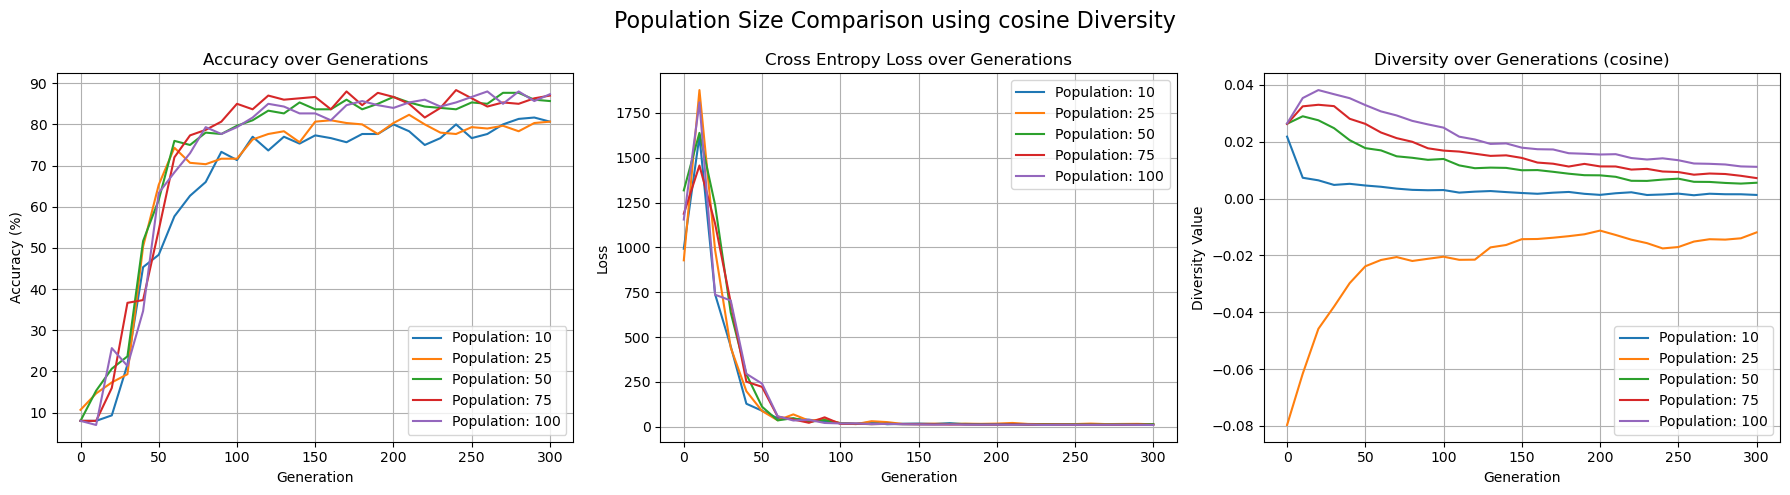

In [31]:
results_by_population = {
    10: (accuracies_p1, losses_p1, diversities_p1),
    25: (accuracies_p2, losses_p2, diversities_p2),
    50: (accuracies_c1, losses_c1, diversities_c1),
    75: (accuracies_p3, losses_p3, diversities_p3),
    100: (accuracies_p4, losses_p4, diversities_p4)
}

plot_population_comparison(results_by_population, metric="cosine")

In [32]:
accuracies_ep1, losses_ep1, diversities_ep1 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=10,
    generations=300
)

accuracies_ep2, losses_ep2, diversities_ep2 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=25,
    generations=300
)

accuracies_ep3, losses_ep3, diversities_ep3 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=75,
    generations=300
)

accuracies_ep4, losses_ep4, diversities_ep4 = test_diversity_parameters(
    metric="euclidean",
    coeff=0.1,
    mutation_rate=0.1,
    mutation_intensity=0.2,
    population_size=100,
    generations=300
)

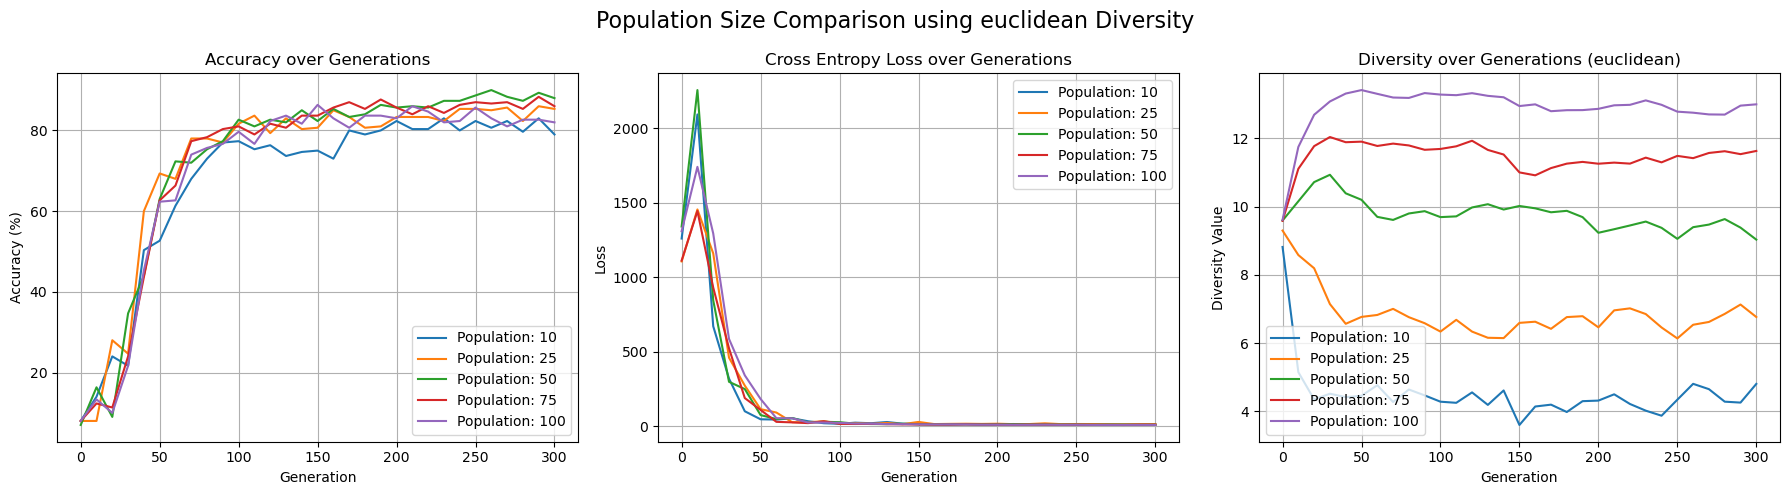

In [33]:
results_by_population_euclidean = {
    10: (accuracies_ep1, losses_ep1, diversities_ep1),
    25: (accuracies_ep2, losses_ep2, diversities_ep2),
    50: (accuracies_e1, losses_e1, diversities_e1),  # Reuse your earlier baseline
    75: (accuracies_ep3, losses_ep3, diversities_ep3),
    100: (accuracies_ep4, losses_ep4, diversities_ep4)
}

plot_population_comparison(results_by_population_euclidean, metric="euclidean")